In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import random

from visualize import Visualize
from IPython.display import Image

In [2]:
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float)
Y = np.array([[0],[1],[1],[0]], dtype=np.float) 
data = X,Y

### Genome Refactor
- <del>Innovation increments on mutate across all genomes</del>
- <del>No recurrent connections allowed</del>
- No recursive connections allowed : In Progress...
- <del>Layers built into connections Genome</del>
- Single mutation per add_node / add_connection (bug fix)

<b>Working on layer ordering! Next, work on non-recursive connections.</b>

In [3]:
class Genome(object):
    '''
    Genome (Genotype) creation and mutation
    * All counting is zero indexed
    '''

    def __init__(self, data):
        self.data = data
        self.nextInnovation = 0

    def create(self):
        '''
        Create a Genome from two sets of genes using the data (X,Y)
        1. Node genes : Defines the number of nodes in the Genome
        2. Connection genes : Defines the connections, weights, and important metadata for the Genome
        3. Return two gene objects as a single Genome (Genotype)
        '''
        X,Y = self.data

        # Each input tensor's column represents a Neural Network Node
        # Ex.: X = np.array([[0,0]]) equals two input nodes
        #      X = np.array([[0,0,0],[0,1,0]]) equals three input nodes
        #      X = np.array([[0,0,0,0],[0,1,0,1],[n,m,o,p],...]) equals four input nodes

        # Count the input (sensor) columns to measure NN input (sensor) nodes
        X_count = X.shape[-1]
        # Count the output (target) columns to measure NN output nodes
        Y_count = Y.shape[-1]

        ### Create a Node Gene DataFrame that represents the data (X,Y) ###
        # Create a list of nodes (numerical increments) and their type (input,sensor)
        node_genes_labels = ['node','type']
        # Create another list with the column count of X as the number of nodes (sensor nodes)
        node_genes = [[i, 'sensor'] for i in range(X_count)]
        # Extend the list to include the output nodes (column count from the Y tensor)
        node_genes.extend([i, 'output'] for i in range(Y_count))
        # Create the DataFrame
        nodes = pd.DataFrame.from_records(node_genes, columns=node_genes_labels)
        # Fix the node count to match the actual number of nodes
        nodes['node'] = nodes.index
        # Apply innovation numbers
        nodes['innovation'] = nodes.index
        # Create the layer information
        nodes.loc[nodes.type == ("sensor"),("layer")] = pd.Series([0]).values
        nodes.loc[nodes.type == ("output"),("layer")] = pd.Series([1]).values
        # Ensure all layer numbers are type int
        nodes['layer'] = nodes['layer'].astype(int)
        # Update nextInnovation
        self.nextInnovation = max(nodes.innovation.values.tolist())+1

        ### Create a Connection Gene DataFrame ###
        connection_gene_labels = ['in', 'out', 'weight', 'enabled']
        connections = pd.DataFrame(columns=connection_gene_labels)
        # Collect nodes from nodes df
        node_count = nodes['node'].values.tolist()
        del node_count[-1]
        # Assign metadata to connections
        for i in node_count:
            connections.loc[i] = [i,i,np.random.uniform(-1.0,1.0),True]

        ## Ensure initial Sensor 'in' and 'out' metadata is correct
        # Create a list of all the output nodes
        output_nodes = sorted(nodes.loc[nodes['type'] == ("output")]['node'].values.tolist())
        # Calculate an integer for all sensor nodes (to assign an output node)
        sensorOutputLen = len(nodes.loc[nodes.type == ("sensor"),:])
        # Assign the sensor connections a random output node
        connections.loc[nodes.type == ("sensor"),('out')] = np.random.randint(output_nodes[0],output_nodes[-1]+1,size=sensorOutputLen)
        # Generate the innovation numbers for the connections
        innovations = []
        for i in range(len(connections)):
            innovations.extend([self.nextInnovation])
            # On the final pass, this also prepares the mutate (add_connection / add_node) innovation number
            self.nextInnovation += 1
        # Assign the innovation numbers to the DataFrame
        connections['innovation'] = innovations

        # Create the Genome (Genotype) Object
        aGenome = nodes,connections
        return aGenome

    def add_node(self,aGenome):
        '''
        Add a new node to the Genome
        1. Split a connection and and a new node
        2. The in weight for the new node is the original connection's weight
        3. The out weight for the new node is 1.00
        4. Innovation number is incremented by +1
        5. Layer order is updated
        '''
        
        nodes,connections = aGenome

        ## Create a new hidden node
        # Calculate next node number
        nextNode = max(nodes.node.values.tolist())+1
        # Create a DataFrame with the new node information
        df = pd.DataFrame([[nextNode,'hidden',self.nextInnovation,0]],columns=['node','type','innovation','layer'])
        # Increment the Innovation Number
        self.nextInnovation += 1
        # Add the new node to the nodes DataFrame
        nodes = nodes.append(df,ignore_index=True)

        ## Split a random enabled connection
        enabled = connections.loc[connections.enabled == True,:]
        sample = enabled.sample().values.tolist()[0]

        ## Create 1st Connection
        # Desc: This connection will intercept an existing connection and use the existing weight value
        
        # Collect the last node number in nodes DataFrame
        # Desc: Since a node was just added, use that as the new input target of this connection
        new_node_num = nodes.tail(1).node.values[0]
        # Copy the connections DataFrame sample
        new_conn_A = sample.copy()
        # Set the innovation number
        new_conn_A[-1] = self.nextInnovation
        # Increment the global innovation number
        self.nextInnovation += 1
        # Update the new connection with the new target node's number
        new_conn_A[1] = new_node_num
        
        ## Create 2nd Connection
        # Desc: This connection will connect first to the new node, and then to the split connection node
        #       Its weight value is set to 1.00. This preserves the weight progress the network has made.
        # Copy the sample connection
        new_conn_B = sample.copy()
        # Set the innovation number
        new_conn_B[-1] = self.nextInnovation
        # Increment the global innovation number
        self.nextInnovation += 1
        # Set the connection weight to 1.00
        new_conn_B[2] = 1.00
        # Set the inbound connection as the outbound connection in new_conn_A
        new_conn_B[0] = new_conn_A[1]

        # Disable the originally selected connection 'sample'
        connections.loc[connections.innovation == (sample[-1]),("enabled")] = False

        ## Append the two new connections to the DataFrame
        df0 = pd.DataFrame([new_conn_A],columns=['in','out','weight','enabled','innovation'])
        df1 = pd.DataFrame([new_conn_B],columns=['in','out','weight','enabled','innovation'])
        connections = connections.append([df0,df1],ignore_index=True)

        aGenome = nodes,connections
        # Create a dictionary of layer numbers and a list of their nodes
        layers = self.create_layers(aGenome)

        ## Set the layer numbers
        for k,v in layers.items():
            # Select nodes v, and create the layer k in the 'layer' column
            nodes.loc[nodes['node'].isin(v), ("layer")] = k
            
        aGenome = nodes,connections
        return aGenome

    def add_connection(self,aGenome):
        '''
        Add a new connection to the Genome
        * Recurrent connections disabled: connections that connect back to the same node
        ** Recursive connections disabled: connections that connect back to a layer before the selected node
        '''

        nodes,connections = aGenome

        # Select all the unique non-output nodes as potential in nodes for the new connection
        # (No connections that will interrupt the intended input data)
        nodes_A = np.unique(nodes.loc[nodes.type != ("output")].node).tolist()
        # Choose a random in node for the new connection
        inNode = random.choice(nodes_A)
        
        ## Remove any nodes if they are in a layer with an identical or smaller number
        #  (no recurrent or recursive connections)
        # Select the layer that inNode is in
        layer_B = (nodes.loc[nodes.node == inNode, ("layer")].values.tolist()[0])+1
        # Select all nodes in bLayer
        nodes_B = nodes.loc[nodes.layer == layer_B,("node")].values.tolist()
        # Choose a random node from bNodes as the outNode
        outNode = random.choice(nodes_B)

        ## Finish generating the remaining connection information
        # Generate a weight for the connection
        aWeight = np.random.uniform(-1.0,1.0)
        # Store all connection information in a list
        metadata = [[inNode,outNode,aWeight,True,self.nextInnovation]]
        
        # Create the new connection
        df = pd.DataFrame(metadata,columns=['in','out','weight','enabled','innovation'])
        # Increment the global innovation number
        self.nextInnovation += 1
        # Add the new connection to the connections DataFrame
        connections = connections.append(df,ignore_index=True)

        aGenome = nodes,connections
        return aGenome

    def mutate(self,aGenome):
        '''
        Randomly mutation a Genome (Genotype)
        '''
        nodes,connections = aGenome
        
        aMutation = random.choice(['node', 'connection'])
        if aMutation == ("node"):
            aGenome = self.add_node(aGenome)
        if aMutation == ("connection") :
            aGenome = self.add_connection(aGenome)
        return aGenome

    def create_layers(self,aGenome):
    
        nodes,connections = aGenome
        layerCount = 0
        layers = {}
    
        ## Which nodes are out nodes of the sensor nodes?
        enabled = connections.loc[connections.enabled == True]
        # Select an array of sensor nodes
        sensorNodes = nodes.loc[nodes.type == ("sensor")].node.unique().tolist()
        # Create a nested list of layer number and nodes belonging to that layer
        layers[layerCount] = sensorNodes
        # Increment the layerCount
        layerCount += 1
        # Select the nodes belonging to the next layer
        nextLayer = enabled.loc[enabled['in'].isin(sensorNodes)]['out'].unique().tolist()
        # Create a list of output nodes
        outputNodes = nodes.loc[nodes.type == ("output"),("node")].unique().tolist()
    
        ## Check if nextLayer is output layer
        #  ** Needs to be optimized
        if nextLayer is outputNodes:
            # Extend the layers list
            layers[layerCount] = nextLayer
            # Return list and end method
            return layers
        # Otherwise, remove output nodes from the nextLayer
        for ix,ele in enumerate(outputNodes):
            if ele in nextLayer:
                nextLayer.remove(ele)
        # Extend the layers list
        layers[layerCount] = nextLayer
        # Increment the layerCount
        layerCount += 1
    
        ## Continue iterating through the remainder of the enabled connections
        #  1. Select nextLayer nodes
        #  2. Remove any output nodes
        #  3. Extend the layers list
        #  ** Needs to be optimized
        for idx,row in enabled.iterrows():
            nextLayer = enabled.loc[enabled['in'].isin(nextLayer)]['out'].unique().tolist()
            for ix,ele in enumerate(outputNodes):
                if ele in nextLayer:
                    nextLayer.remove(ele)        
            # Once the output nodes have been reached, break the loop
            if len(nextLayer) == 0:
                break
            else:
                layers[layerCount] = nextLayer
                layerCount += 1
    
        # Finally, extend the layers list with the output nodes and the layer number
        layers[layerCount] = outputNodes
    
        return layers

In [4]:
g = Genome(data)
GENOME = g.create()
for _ in range(100):
    GENOME = g.mutate(GENOME)

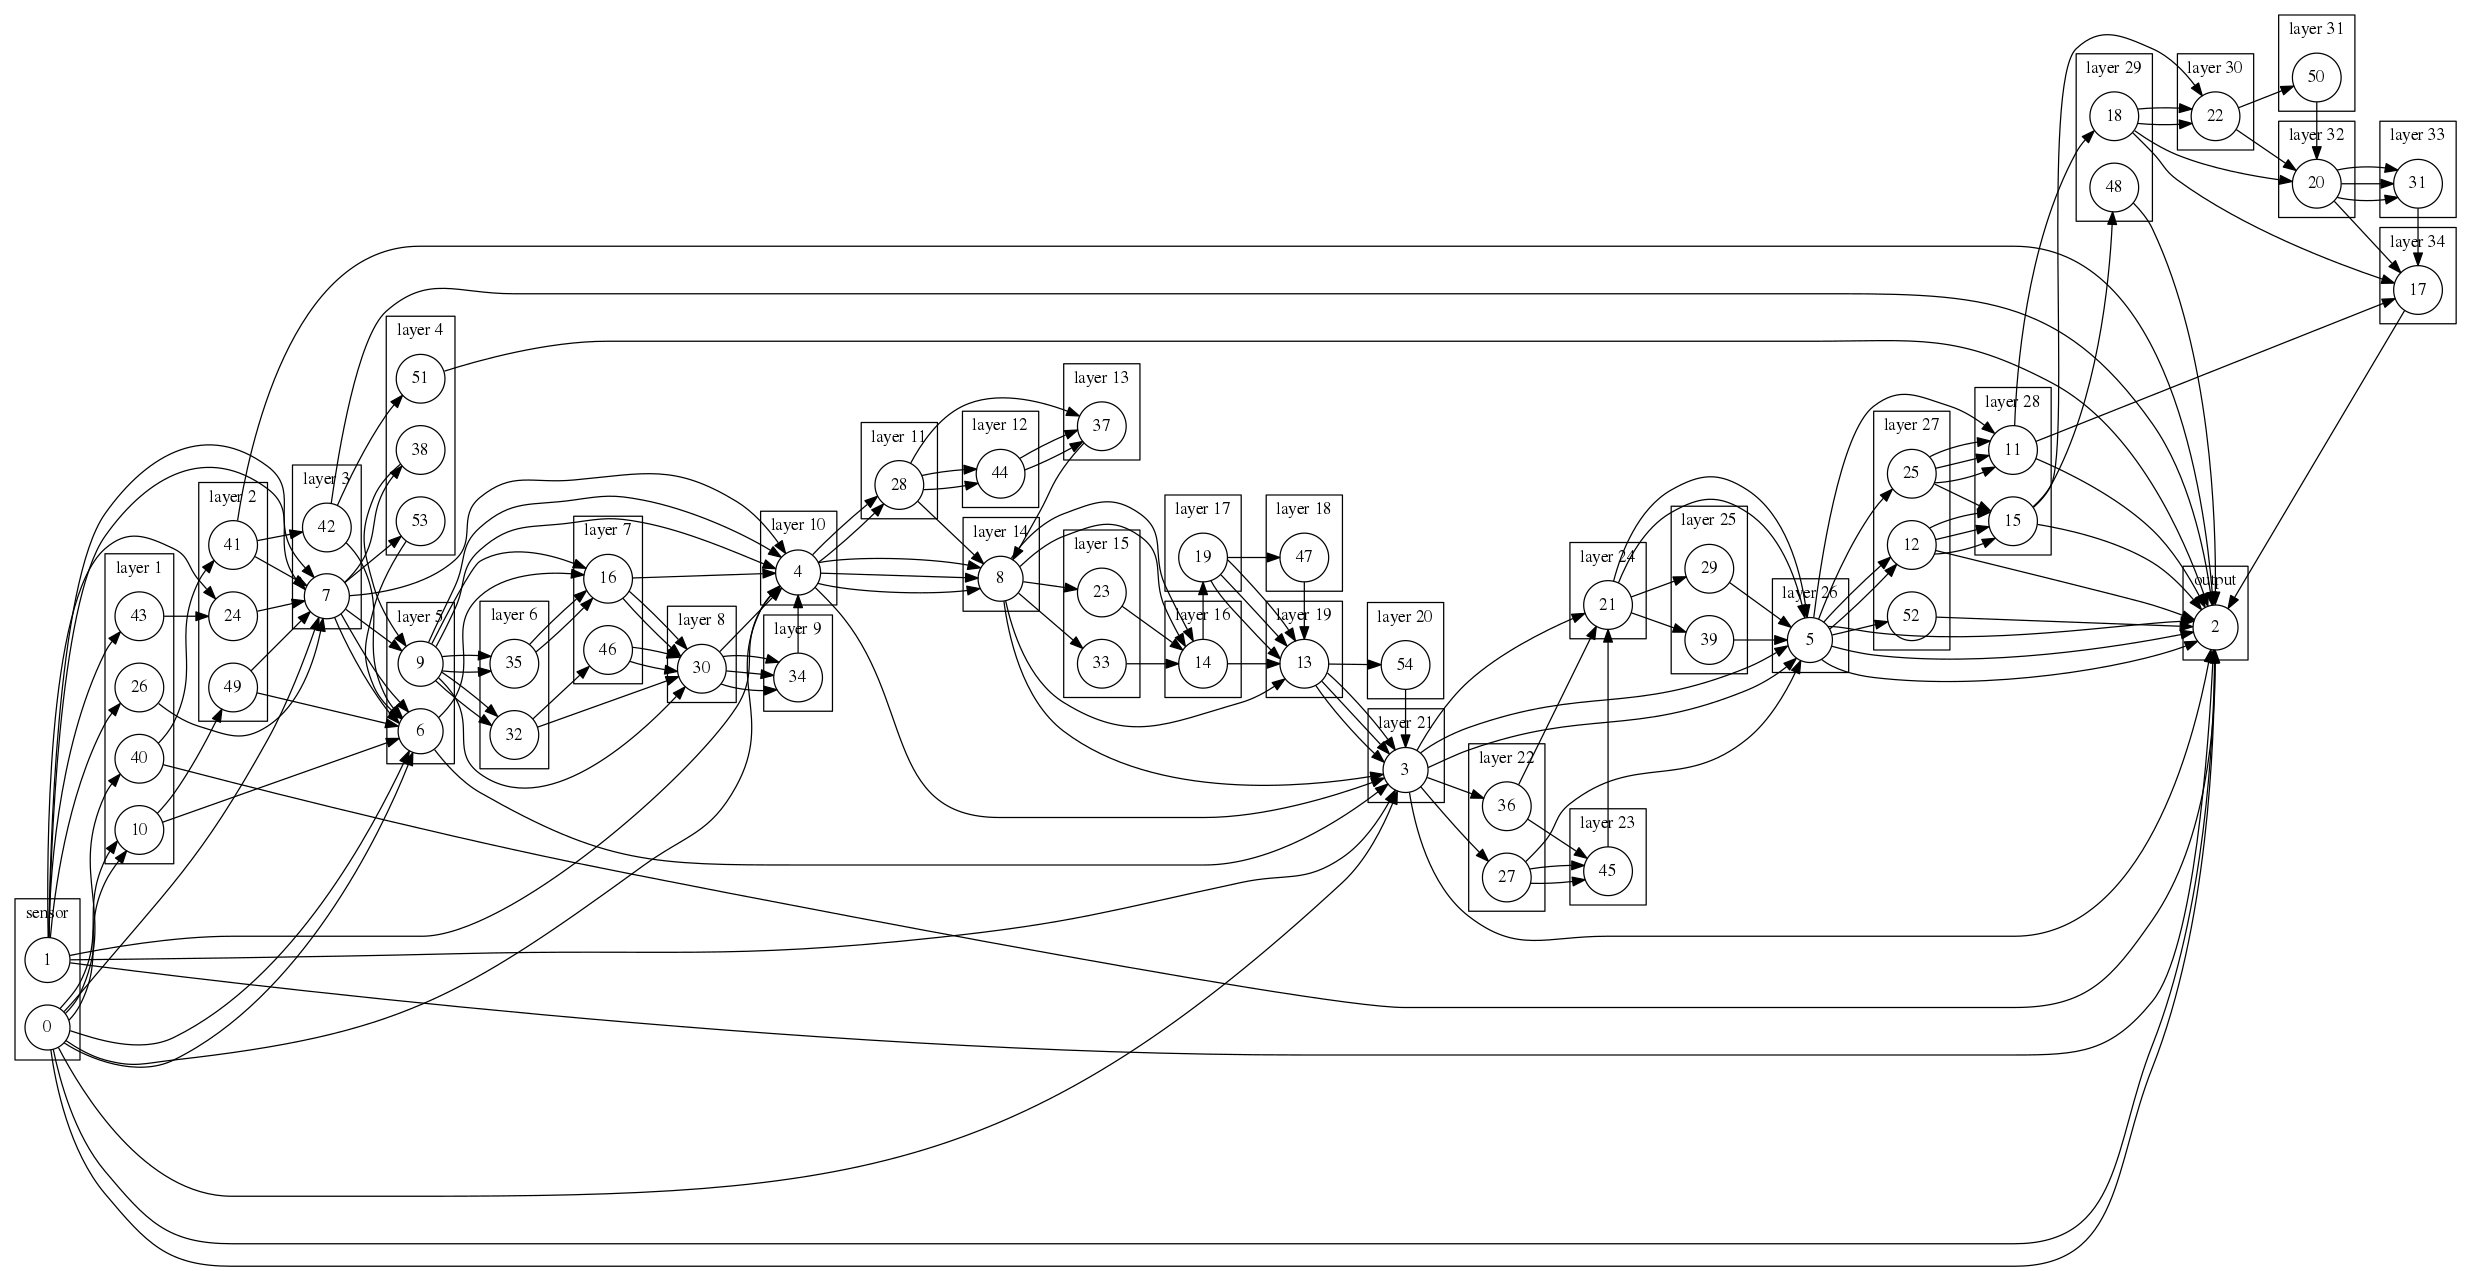

In [5]:
v = Visualize(GENOME)
Image(v.create())